## Задание

1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, выберите оптимальное значение.

2. Примените нормализацию данных. Исследуйте скорость сходимости.

3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления скрытого слоя, Удаления/добавления нейронов в каждом слое.

4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях. (https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации. (https://pytorch.org/docs/stable/optim.html)

6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

## Решение

### Импорт

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch

from torch import nn, optim

import torch.nn.functional as F

from common.progressbar import log_progress

### Настройки

In [2]:
RANDOM_STATE = 42

EPOCHS = 2000

# Папка лабораторной
DIR_LAB = 'Lab8'

# Папка для загруженных данных
DIR_DATA = 'data'

# Файлы с данными
FILE_DATA = 'weatherAUS.csv'

In [3]:
PATH_DATA = os.path.join(DIR_LAB, DIR_DATA, FILE_DATA)

In [4]:
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Данные

Предсказание погоды на следующий день: 
Будет дождь, если rainfall >=1

In [6]:
df = pd.read_csv(PATH_DATA)[['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']].dropna()

df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0,0
1,0.0,25.0,1010.6,0,0
2,0.0,30.0,1007.6,0,0
3,0.0,16.0,1017.6,0,0
4,1.0,33.0,1010.8,0,0


In [7]:
df['RainTomorrow'].value_counts()

RainTomorrow
0    97103
1    27586
Name: count, dtype: int64

Классы несбалансированы!

### Разделяем данные

In [8]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']].to_numpy()
y = df[['RainTomorrow']].to_numpy()

_X_train, _X_test, _y_train, _y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Преобразуем в тензор

In [9]:
def to_tensor(data, squeeze=False):
    if squeeze:
        return torch.squeeze(torch.from_numpy(data).float()).to(device)
    else:
        return torch.from_numpy(data).float().to(device)

In [10]:
X_train = to_tensor(_X_train)
y_train = to_tensor(_y_train, squeeze=True)

X_test = to_tensor(_X_test)
y_test = to_tensor(_y_test, squeeze=True)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


### Функции

#### Подсчёт точности

In [11]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    return (y_true == predicted).sum().float() / len(y_true)

#### Тренировка модели

In [12]:
def run_training(model, optimizer, criterion, epochs, X_train, X_test, y_train, y_test, test_step=100):
    test_losses = []
    test_accuracies = []

    for epoch in log_progress(range(epochs + 1), name='Epochs'):
        model.train()

        train_loss = 0
        
        y_pred = model(X_train)
        y_pred = torch.squeeze(y_pred)

        train_loss = criterion(y_pred, y_train)
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch % test_step == 0:
            model.eval()

            with torch.no_grad():
                y_test_pred = net(X_test)
                y_test_pred = torch.squeeze(y_test_pred)

                test_loss = criterion(y_test_pred, y_test)
                test_acc = calculate_accuracy(y_test, y_test_pred)

                print(f'Epoch {epoch}: Test set - loss: {test_loss:.10f}, accuracy: {test_acc:.10f}')

                test_losses.append(test_loss)
                test_accuracies.append(test_acc)
    
    return test_losses, test_accuracies

#### График потерь и точности по эпохам

In [13]:
def results_graphs(results, epochs, test_step=100):
    epochs = range(0, EPOCHS + 1, 100)

    for param, scores in results.items():
        losses = [loss.detach().cpu().numpy() for loss in scores["loss"]]
        accuracies = [accuracy.detach().cpu().numpy() for accuracy in scores["accuracy"]]

        fig, ax1 = plt.subplots(figsize=(6, 4))

        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        lplot, = ax1.plot(epochs, losses, label=f'Loss', color='tab:red')
        ax1.tick_params(axis='y', labelcolor='tab:red')
        ax1.grid(True, linestyle="--", alpha=0.7)
        ax1.set_yscale('log')

        ax2 = ax1.twinx()
        ax2.set_ylabel('Accuracy')
        aplot, = ax2.plot(epochs, accuracies, label=f'Accuracy', color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue')

        plt.title(f'{param}')
        plt.legend(handles=[lplot, aplot], loc='upper left')

        plt.show()

### 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, выберите оптимальное значение.

#### NN model

In [14]:
class Net(nn.Module):
    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)
    
        # torch.nn.init.xavier_uniform_(self.fc1.weight) 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [15]:
learning_rates = [ 0.0001, 0.001, 0.01, 0.1 ]

In [16]:
lr_results = {}

for lr in log_progress(learning_rates, name='Learning rates'):
    net = Net(4)
    optimizer = optim.Adam(net.parameters(), lr=lr)

    net = net.to(device)
    criterion = nn.BCELoss().to(device)

    losses, accuracies = run_training(net, optimizer, criterion, EPOCHS, X_train, X_test, y_train, y_test)

    lr_results[lr] = {'loss': losses, 'accuracy': accuracies}

Epoch 0: Test set - loss: 7.1646285057, accuracy: 0.2216697484
Epoch 100: Test set - loss: 0.5720732212, accuracy: 0.7959740162
Epoch 200: Test set - loss: 0.5436037779, accuracy: 0.7788916826
Epoch 300: Test set - loss: 0.5333544612, accuracy: 0.7793327570
Epoch 400: Test set - loss: 0.5154787302, accuracy: 0.7796936631
Epoch 500: Test set - loss: 0.4807432592, accuracy: 0.7794530392
Epoch 600: Test set - loss: 0.4678120911, accuracy: 0.7808966041
Epoch 700: Test set - loss: 0.4557594955, accuracy: 0.7848664522
Epoch 800: Test set - loss: 0.4444381893, accuracy: 0.7911219597
Epoch 900: Test set - loss: 0.4336556494, accuracy: 0.7986205816
Epoch 1000: Test set - loss: 0.4242183268, accuracy: 0.8103697300
Epoch 1100: Test set - loss: 0.4173144996, accuracy: 0.8223995566
Epoch 1200: Test set - loss: 0.4123701453, accuracy: 0.8278931975
Epoch 1300: Test set - loss: 0.4091722965, accuracy: 0.8314620256
Epoch 1400: Test set - loss: 0.4069587588, accuracy: 0.8331863284
Epoch 1500: Test set -

Epoch 0: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 100: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 200: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 300: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 400: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 500: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 600: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 700: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 800: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 900: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 1000: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 1100: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 1200: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 1300: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 1400: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 1

Epoch 0: Test set - loss: 5.1279621124, accuracy: 0.2214692384
Epoch 100: Test set - loss: 0.4126811326, accuracy: 0.8274520636
Epoch 200: Test set - loss: 0.4038833380, accuracy: 0.8355521560
Epoch 300: Test set - loss: 0.4027727842, accuracy: 0.8363942504
Epoch 400: Test set - loss: 0.4019065201, accuracy: 0.8362338543
Epoch 500: Test set - loss: 0.4012069106, accuracy: 0.8370759487
Epoch 600: Test set - loss: 0.4006967843, accuracy: 0.8370759487
Epoch 700: Test set - loss: 0.4003363550, accuracy: 0.8370759487
Epoch 800: Test set - loss: 0.4000843465, accuracy: 0.8369556665
Epoch 900: Test set - loss: 0.3999073207, accuracy: 0.8371160626
Epoch 1000: Test set - loss: 0.3998060524, accuracy: 0.8373165727
Epoch 1100: Test set - loss: 0.3997400999, accuracy: 0.8373165727
Epoch 1200: Test set - loss: 0.3996966481, accuracy: 0.8375170231
Epoch 1300: Test set - loss: 0.3996661007, accuracy: 0.8376774192
Epoch 1400: Test set - loss: 0.3996430337, accuracy: 0.8376373649
Epoch 1500: Test set -

Epoch 0: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 100: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 200: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 300: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 400: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 500: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 600: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 700: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 800: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 900: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 1000: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 1100: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 1200: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 1300: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 1400: Test set - loss: 77.8450546265, accuracy: 0.2215494365
Epoch 1

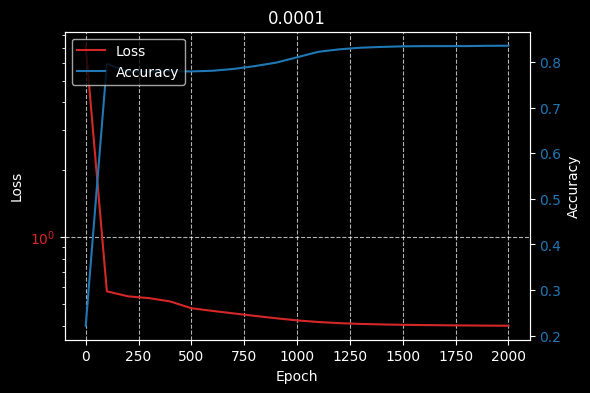

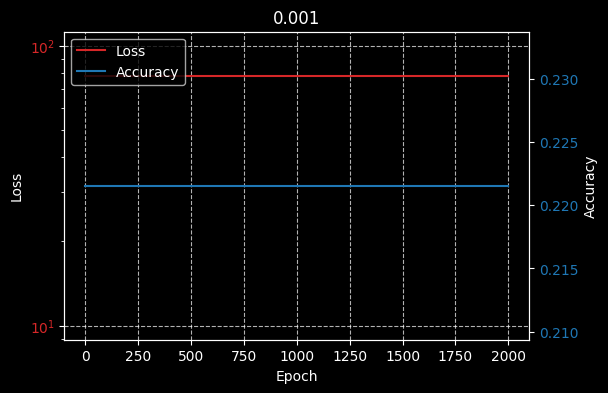

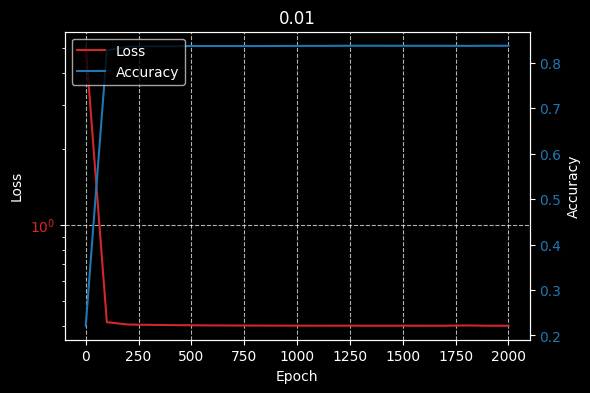

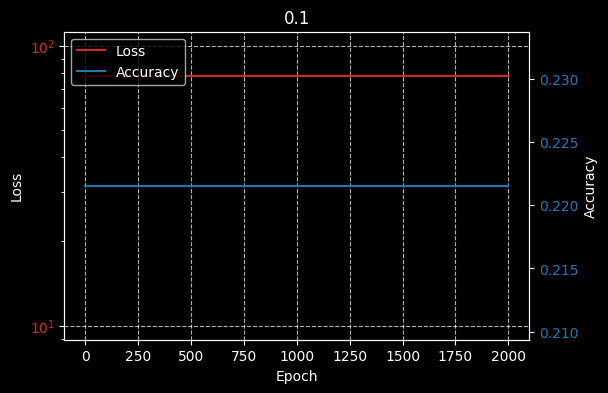

In [17]:
results_graphs(lr_results, EPOCHS)

In [18]:
optimal_learning_rate = 0.0001

### 2. Примените нормализацию данных. Исследуйте скорость сходимости.

In [19]:
scalers = { 'No Scaler': None, 'MinMaxScaler': MinMaxScaler(), 'StandardScaler': StandardScaler() }

In [20]:
scaler_results = {}

for scaler_name, scaler in log_progress(scalers.items(), name='Scaling methods'):
    if scaler is not None:
        s_X_train = scaler.fit_transform(_X_train)
        s_X_test = scaler.transform(_X_test)

        X_train = to_tensor(s_X_train)
        X_test = to_tensor(s_X_test)
    else:
        X_train = to_tensor(_X_train)
        X_test = to_tensor(_X_test)

    net = Net(4)
    optimizer = optim.Adam(net.parameters(), lr=optimal_learning_rate)
    net = net.to(device)
    criterion = nn.BCELoss().to(device)

    losses, accuracies = run_training(net, optimizer, criterion, EPOCHS, X_train, X_test, y_train, y_test)

    scaler_results[scaler_name] = {'loss': losses, 'accuracy': accuracies}

Epoch 0: Test set - loss: 4.1329903603, accuracy: 0.2199855596
Epoch 100: Test set - loss: 0.8707419634, accuracy: 0.4578554928
Epoch 200: Test set - loss: 0.7497244477, accuracy: 0.7501804233
Epoch 300: Test set - loss: 0.7393576503, accuracy: 0.7651375532
Epoch 400: Test set - loss: 0.7285189033, accuracy: 0.7686662674
Epoch 500: Test set - loss: 0.7171112299, accuracy: 0.7736787200
Epoch 600: Test set - loss: 0.7052820921, accuracy: 0.7766861916
Epoch 700: Test set - loss: 0.6931723356, accuracy: 0.7782500386
Epoch 800: Test set - loss: 0.6809003353, accuracy: 0.7784505486
Epoch 900: Test set - loss: 0.6685554981, accuracy: 0.7784505486
Epoch 1000: Test set - loss: 0.6562113762, accuracy: 0.7784505486
Epoch 1100: Test set - loss: 0.6439273953, accuracy: 0.7784505486
Epoch 1200: Test set - loss: 0.6317505836, accuracy: 0.7784505486
Epoch 1300: Test set - loss: 0.6197105050, accuracy: 0.7784505486
Epoch 1400: Test set - loss: 0.6078498363, accuracy: 0.7784505486
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.6014785171, accuracy: 0.7784505486
Epoch 100: Test set - loss: 0.5957494378, accuracy: 0.7784505486
Epoch 200: Test set - loss: 0.5888777375, accuracy: 0.7784505486
Epoch 300: Test set - loss: 0.5818167329, accuracy: 0.7784505486
Epoch 400: Test set - loss: 0.5750132203, accuracy: 0.7784505486
Epoch 500: Test set - loss: 0.5683084726, accuracy: 0.7784505486
Epoch 600: Test set - loss: 0.5616887808, accuracy: 0.7784505486
Epoch 700: Test set - loss: 0.5552266836, accuracy: 0.7784505486
Epoch 800: Test set - loss: 0.5490193367, accuracy: 0.7784505486
Epoch 900: Test set - loss: 0.5431563854, accuracy: 0.7784505486
Epoch 1000: Test set - loss: 0.5377066135, accuracy: 0.7784505486
Epoch 1100: Test set - loss: 0.5327057242, accuracy: 0.7784505486
Epoch 1200: Test set - loss: 0.5281479955, accuracy: 0.7784505486
Epoch 1300: Test set - loss: 0.5239885449, accuracy: 0.7784505486
Epoch 1400: Test set - loss: 0.5201675296, accuracy: 0.7784505486
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.5324840546, accuracy: 0.7784505486
Epoch 100: Test set - loss: 0.5249096751, accuracy: 0.7784505486
Epoch 200: Test set - loss: 0.5172787905, accuracy: 0.7784505486
Epoch 300: Test set - loss: 0.5095303655, accuracy: 0.7784505486
Epoch 400: Test set - loss: 0.5016234517, accuracy: 0.7784505486
Epoch 500: Test set - loss: 0.4936136603, accuracy: 0.7784505486
Epoch 600: Test set - loss: 0.4855952859, accuracy: 0.7784505486
Epoch 700: Test set - loss: 0.4775974154, accuracy: 0.7784505486
Epoch 800: Test set - loss: 0.4696368873, accuracy: 0.7784505486
Epoch 900: Test set - loss: 0.4617780149, accuracy: 0.7784505486
Epoch 1000: Test set - loss: 0.4542384744, accuracy: 0.7784505486
Epoch 1100: Test set - loss: 0.4471662343, accuracy: 0.7784505486
Epoch 1200: Test set - loss: 0.4405345321, accuracy: 0.7784505486
Epoch 1300: Test set - loss: 0.4343771935, accuracy: 0.7795733213
Epoch 1400: Test set - loss: 0.4287152588, accuracy: 0.7831823230
Epoch 1500: Test set -

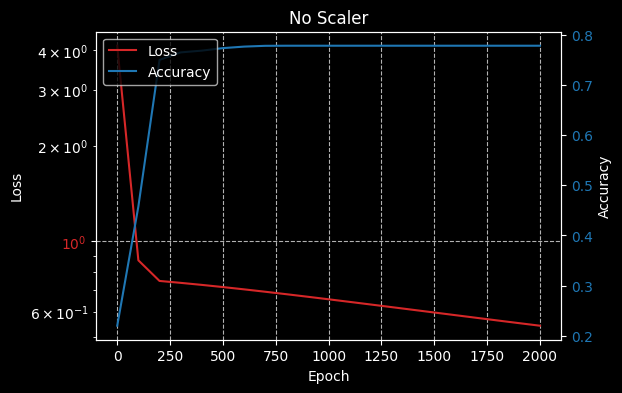

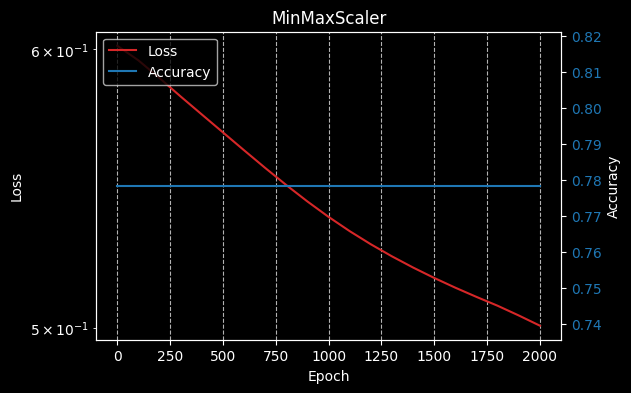

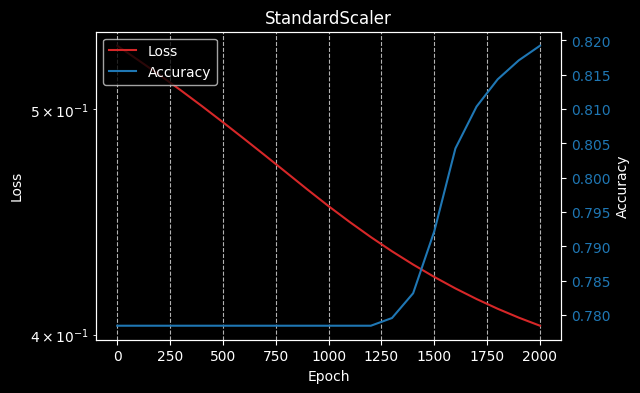

In [21]:
results_graphs(scaler_results, EPOCHS)

In [22]:
optimal_scaler = StandardScaler()

#X_train = to_tensor(_X_train)
#X_test = to_tensor(_X_test)

s_X_train = scaler.fit_transform(_X_train)
s_X_test = scaler.transform(_X_test)

X_train = to_tensor(s_X_train)
X_test = to_tensor(s_X_test)

### 3. Измените струтуру сети. 

Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления скрытого слоя, Удаления/добавления нейронов в каждом слое.

In [23]:
class NetCustomArch(nn.Module):
    def __init__(self, n_features, architecture):
        super(NetCustomArch, self).__init__()

        layers = []
        input_size = n_features

        for layer_size in architecture:
            layers.append(nn.Linear(input_size, layer_size))
            layers.append(nn.ReLU())
            input_size = layer_size

        layers.append(nn.Linear(input_size, 1))
        layers.append(nn.Sigmoid())

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [24]:
architectures = {
    'None':         [],                 # Без скрытых слоёв
    '2':            [2],                # Один скрытый слой на 2 нейрона
    '4':            [4],                # Один скрытый слой на 4 нейрона
    '8':            [8],                # Один скрытый слой на 8 нейронов
    '4-2':          [4, 2],             # 2 скрытых слоя c 4-мя и 2-мя нейронами
    '8-4':          [8, 4],             # Как в прошлых примерах - 2 скрытых слоя с 8-ю и 4-мя нейронами
    '16-8':         [16, 8],            # 2 скрытых слоя c 16-ю и 4-мя нейронами
    '8-4-2':        [8, 4, 2],          # 3 скрытых слоя
    '16-8-4':       [16, 8, 4],         # 3 скрытых слоя
    '32-16-8-4':    [32, 16, 8, 4]      # 4 скрытых слоя
}

In [25]:
arch_results = {}

for arch_name, arch in log_progress(architectures.items(), name='Architectures'):
    net = NetCustomArch(4, arch)
    optimizer = optim.Adam(net.parameters(), lr=optimal_learning_rate)
    
    net = net.to(device)
    criterion = nn.BCELoss().to(device)

    losses, accuracies = run_training(net, optimizer, criterion, EPOCHS, X_train, X_test, y_train, y_test)

    arch_results[arch_name] = {'loss': losses, 'accuracy': accuracies}

Epoch 0: Test set - loss: 0.8136317134, accuracy: 0.5237388611
Epoch 100: Test set - loss: 0.8035104275, accuracy: 0.5336835384
Epoch 200: Test set - loss: 0.7935925126, accuracy: 0.5429465175
Epoch 300: Test set - loss: 0.7838761806, accuracy: 0.5522496104
Epoch 400: Test set - loss: 0.7743579149, accuracy: 0.5614724755
Epoch 500: Test set - loss: 0.7650340199, accuracy: 0.5692116618
Epoch 600: Test set - loss: 0.7559010386, accuracy: 0.5777929425
Epoch 700: Test set - loss: 0.7469556332, accuracy: 0.5868554115
Epoch 800: Test set - loss: 0.7381947637, accuracy: 0.5946747661
Epoch 900: Test set - loss: 0.7296151519, accuracy: 0.6034165025
Epoch 1000: Test set - loss: 0.7212138772, accuracy: 0.6116368771
Epoch 1100: Test set - loss: 0.7129878998, accuracy: 0.6199775338
Epoch 1200: Test set - loss: 0.7049345970, accuracy: 0.6285187006
Epoch 1300: Test set - loss: 0.6970511675, accuracy: 0.6366187930
Epoch 1400: Test set - loss: 0.6893351674, accuracy: 0.6454005837
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.7311277986, accuracy: 0.2215494365
Epoch 100: Test set - loss: 0.7271029949, accuracy: 0.2215494365
Epoch 200: Test set - loss: 0.7233037949, accuracy: 0.2215494365
Epoch 300: Test set - loss: 0.7196663618, accuracy: 0.2215494365
Epoch 400: Test set - loss: 0.7161368132, accuracy: 0.2215494365
Epoch 500: Test set - loss: 0.7126568556, accuracy: 0.2215494365
Epoch 600: Test set - loss: 0.7091576457, accuracy: 0.2215494365
Epoch 700: Test set - loss: 0.7055179477, accuracy: 0.2215494365
Epoch 800: Test set - loss: 0.7016044259, accuracy: 0.2215494365
Epoch 900: Test set - loss: 0.6972890496, accuracy: 0.2215494365
Epoch 1000: Test set - loss: 0.6927889585, accuracy: 0.2215494365
Epoch 1100: Test set - loss: 0.6884421706, accuracy: 0.2215494365
Epoch 1200: Test set - loss: 0.6842588186, accuracy: 0.2773277760
Epoch 1300: Test set - loss: 0.6802283525, accuracy: 0.8158633709
Epoch 1400: Test set - loss: 0.6762774587, accuracy: 0.8175074458
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.8002299070, accuracy: 0.2173389941
Epoch 100: Test set - loss: 0.7892443538, accuracy: 0.2189028859
Epoch 200: Test set - loss: 0.7781925797, accuracy: 0.2294089347
Epoch 300: Test set - loss: 0.7670341730, accuracy: 0.2565963566
Epoch 400: Test set - loss: 0.7557740211, accuracy: 0.2921645641
Epoch 500: Test set - loss: 0.7444086075, accuracy: 0.3315021396
Epoch 600: Test set - loss: 0.7329630852, accuracy: 0.3735263348
Epoch 700: Test set - loss: 0.7214437127, accuracy: 0.4160317481
Epoch 800: Test set - loss: 0.7098785639, accuracy: 0.4575747848
Epoch 900: Test set - loss: 0.6982952356, accuracy: 0.4974737465
Epoch 1000: Test set - loss: 0.6867158413, accuracy: 0.5360494256
Epoch 1100: Test set - loss: 0.6751656532, accuracy: 0.5736626983
Epoch 1200: Test set - loss: 0.6636482477, accuracy: 0.6058625579
Epoch 1300: Test set - loss: 0.6521920562, accuracy: 0.6351351142
Epoch 1400: Test set - loss: 0.6408191323, accuracy: 0.6596760154
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.7564946413, accuracy: 0.3446146548
Epoch 100: Test set - loss: 0.7407653928, accuracy: 0.3805838525
Epoch 200: Test set - loss: 0.7257064581, accuracy: 0.4167535603
Epoch 300: Test set - loss: 0.7110965848, accuracy: 0.4562515020
Epoch 400: Test set - loss: 0.6967265010, accuracy: 0.5030475855
Epoch 500: Test set - loss: 0.6824001670, accuracy: 0.5484401584
Epoch 600: Test set - loss: 0.6680124402, accuracy: 0.5963189006
Epoch 700: Test set - loss: 0.6535452008, accuracy: 0.6456813216
Epoch 800: Test set - loss: 0.6390292048, accuracy: 0.6923169494
Epoch 900: Test set - loss: 0.6245444417, accuracy: 0.7314540148
Epoch 1000: Test set - loss: 0.6102144122, accuracy: 0.7643756270
Epoch 1100: Test set - loss: 0.5961004496, accuracy: 0.7900794148
Epoch 1200: Test set - loss: 0.5822482705, accuracy: 0.8074424863
Epoch 1300: Test set - loss: 0.5686935782, accuracy: 0.8199936152
Epoch 1400: Test set - loss: 0.5555073619, accuracy: 0.8270511031
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.9394075274, accuracy: 0.2215494365
Epoch 100: Test set - loss: 0.9348950982, accuracy: 0.2215494365
Epoch 200: Test set - loss: 0.9301701784, accuracy: 0.2215494365
Epoch 300: Test set - loss: 0.9248797894, accuracy: 0.2215494365
Epoch 400: Test set - loss: 0.9185881019, accuracy: 0.2215494365
Epoch 500: Test set - loss: 0.9111456871, accuracy: 0.2215494365
Epoch 600: Test set - loss: 0.9019407034, accuracy: 0.2215494365
Epoch 700: Test set - loss: 0.8869395256, accuracy: 0.2215494365
Epoch 800: Test set - loss: 0.8707345128, accuracy: 0.2215494365
Epoch 900: Test set - loss: 0.8546181917, accuracy: 0.2215494365
Epoch 1000: Test set - loss: 0.8381522298, accuracy: 0.2215494365
Epoch 1100: Test set - loss: 0.8211564422, accuracy: 0.2218702435
Epoch 1200: Test set - loss: 0.8035645485, accuracy: 0.2236747146
Epoch 1300: Test set - loss: 0.7853701711, accuracy: 0.2312535048
Epoch 1400: Test set - loss: 0.7666437030, accuracy: 0.2452081144
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.6827021837, accuracy: 0.6180928946
Epoch 100: Test set - loss: 0.6708576083, accuracy: 0.6808885932
Epoch 200: Test set - loss: 0.6602268815, accuracy: 0.7612478733
Epoch 300: Test set - loss: 0.6505804062, accuracy: 0.7847461700
Epoch 400: Test set - loss: 0.6416392922, accuracy: 0.7859491706
Epoch 500: Test set - loss: 0.6333145499, accuracy: 0.7868714333
Epoch 600: Test set - loss: 0.6254192591, accuracy: 0.7886759043
Epoch 700: Test set - loss: 0.6177607775, accuracy: 0.7901595831
Epoch 800: Test set - loss: 0.6101458073, accuracy: 0.7923650742
Epoch 900: Test set - loss: 0.6024441123, accuracy: 0.7957333922
Epoch 1000: Test set - loss: 0.5945922732, accuracy: 0.8001042604
Epoch 1100: Test set - loss: 0.5865484476, accuracy: 0.8051167130
Epoch 1200: Test set - loss: 0.5780977607, accuracy: 0.8091667295
Epoch 1300: Test set - loss: 0.5681822896, accuracy: 0.8133772016
Epoch 1400: Test set - loss: 0.5560559034, accuracy: 0.8163445592
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.6999818683, accuracy: 0.2627315819
Epoch 100: Test set - loss: 0.6866120696, accuracy: 0.7414788604
Epoch 200: Test set - loss: 0.6698728204, accuracy: 0.7753227949
Epoch 300: Test set - loss: 0.6501389742, accuracy: 0.7784505486
Epoch 400: Test set - loss: 0.6267073750, accuracy: 0.7784505486
Epoch 500: Test set - loss: 0.6013252139, accuracy: 0.7784505486
Epoch 600: Test set - loss: 0.5752060413, accuracy: 0.7784505486
Epoch 700: Test set - loss: 0.5492514968, accuracy: 0.7784505486
Epoch 800: Test set - loss: 0.5245136619, accuracy: 0.7784505486
Epoch 900: Test set - loss: 0.5014657378, accuracy: 0.7784505486
Epoch 1000: Test set - loss: 0.4808088839, accuracy: 0.7784505486
Epoch 1100: Test set - loss: 0.4632327259, accuracy: 0.7784505486
Epoch 1200: Test set - loss: 0.4489152133, accuracy: 0.7784505486
Epoch 1300: Test set - loss: 0.4376474619, accuracy: 0.7784505486
Epoch 1400: Test set - loss: 0.4290921986, accuracy: 0.7784505486
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.9233947396, accuracy: 0.2215494365
Epoch 100: Test set - loss: 0.9190692306, accuracy: 0.2215494365
Epoch 200: Test set - loss: 0.9147766232, accuracy: 0.2215494365
Epoch 300: Test set - loss: 0.9105171561, accuracy: 0.2215494365
Epoch 400: Test set - loss: 0.9062904119, accuracy: 0.2215494365
Epoch 500: Test set - loss: 0.9020959735, accuracy: 0.2215494365
Epoch 600: Test set - loss: 0.8979335427, accuracy: 0.2215494365
Epoch 700: Test set - loss: 0.8938024640, accuracy: 0.2215494365
Epoch 800: Test set - loss: 0.8897027969, accuracy: 0.2215494365
Epoch 900: Test set - loss: 0.8856340051, accuracy: 0.2215494365
Epoch 1000: Test set - loss: 0.8815954328, accuracy: 0.2215494365
Epoch 1100: Test set - loss: 0.8775871396, accuracy: 0.2215494365
Epoch 1200: Test set - loss: 0.8736088276, accuracy: 0.2215494365
Epoch 1300: Test set - loss: 0.8696597815, accuracy: 0.2215494365
Epoch 1400: Test set - loss: 0.8657400608, accuracy: 0.2215494365
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.7124850750, accuracy: 0.2504210472
Epoch 100: Test set - loss: 0.6940640807, accuracy: 0.4318710566
Epoch 200: Test set - loss: 0.6743228436, accuracy: 0.7871120572
Epoch 300: Test set - loss: 0.6519778967, accuracy: 0.7873927355
Epoch 400: Test set - loss: 0.6268049479, accuracy: 0.7784505486
Epoch 500: Test set - loss: 0.5990114212, accuracy: 0.7784505486
Epoch 600: Test set - loss: 0.5692210197, accuracy: 0.7784505486
Epoch 700: Test set - loss: 0.5386537313, accuracy: 0.7784505486
Epoch 800: Test set - loss: 0.5090665221, accuracy: 0.7784505486
Epoch 900: Test set - loss: 0.4824568033, accuracy: 0.7784505486
Epoch 1000: Test set - loss: 0.4601792991, accuracy: 0.7785307765
Epoch 1100: Test set - loss: 0.4427032173, accuracy: 0.7799342275
Epoch 1200: Test set - loss: 0.4296423197, accuracy: 0.7899590731
Epoch 1300: Test set - loss: 0.4201195240, accuracy: 0.8035929203
Epoch 1400: Test set - loss: 0.4132691324, accuracy: 0.8138984442
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.7406596541, accuracy: 0.2215494365
Epoch 100: Test set - loss: 0.7321791053, accuracy: 0.2215494365
Epoch 200: Test set - loss: 0.7215936184, accuracy: 0.2215494365
Epoch 300: Test set - loss: 0.7005485296, accuracy: 0.2619295716
Epoch 400: Test set - loss: 0.6653081775, accuracy: 0.8216376901
Epoch 500: Test set - loss: 0.6181737185, accuracy: 0.8363942504
Epoch 600: Test set - loss: 0.5599573851, accuracy: 0.8388804197
Epoch 700: Test set - loss: 0.4979828000, accuracy: 0.8396824002
Epoch 800: Test set - loss: 0.4459804893, accuracy: 0.8399631381
Epoch 900: Test set - loss: 0.4124196768, accuracy: 0.8405244946
Epoch 1000: Test set - loss: 0.3944179118, accuracy: 0.8404042125
Epoch 1100: Test set - loss: 0.3855300248, accuracy: 0.8406447768
Epoch 1200: Test set - loss: 0.3811316192, accuracy: 0.8412061930
Epoch 1300: Test set - loss: 0.3787558675, accuracy: 0.8416873813
Epoch 1400: Test set - loss: 0.3772426844, accuracy: 0.8420482874
Epoch 1500: Test set -

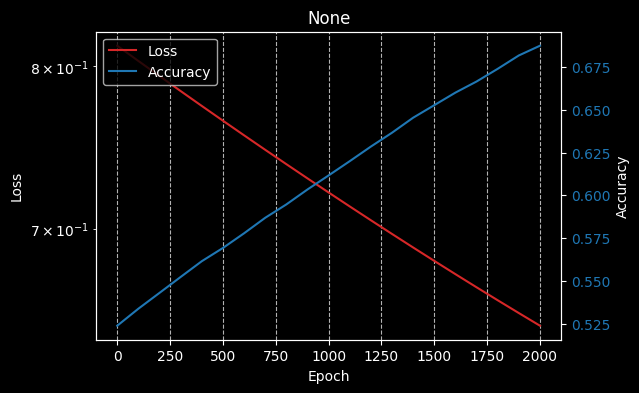

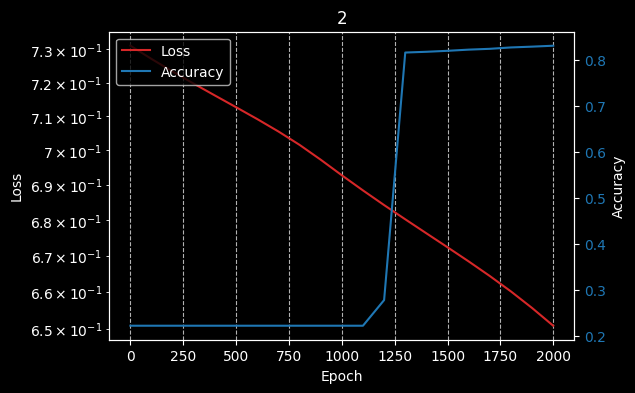

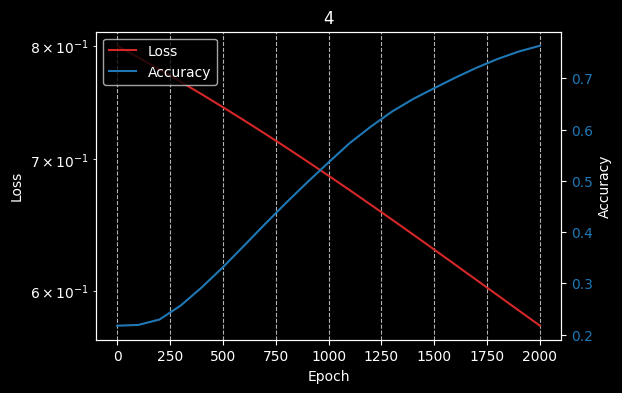

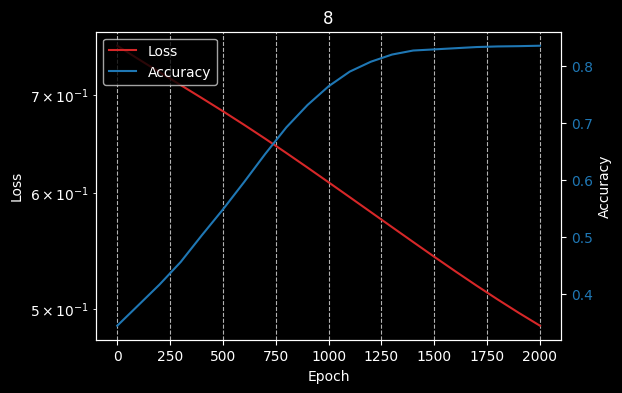

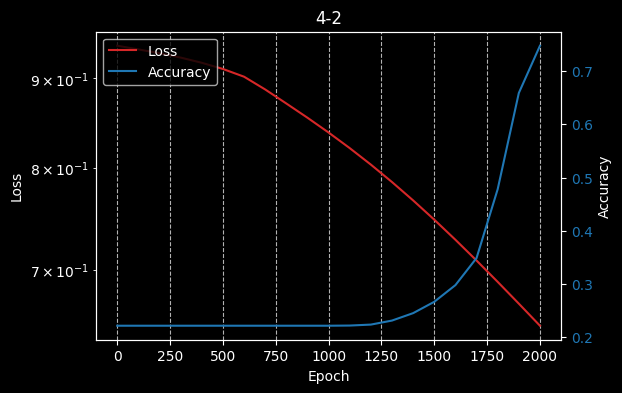

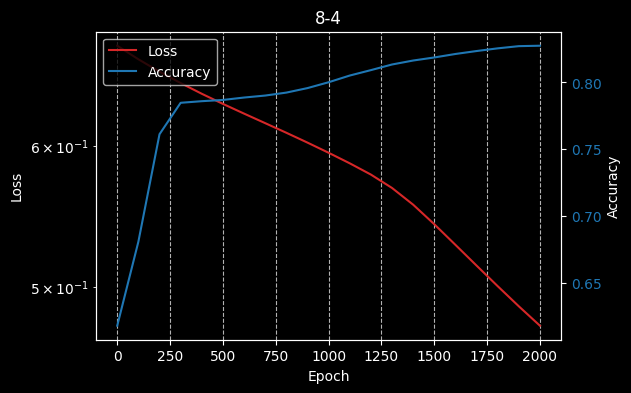

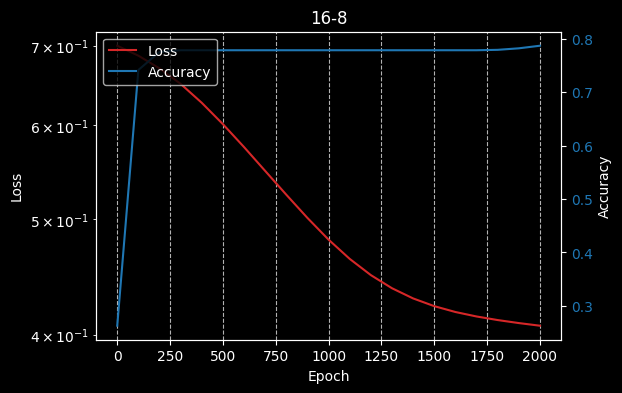

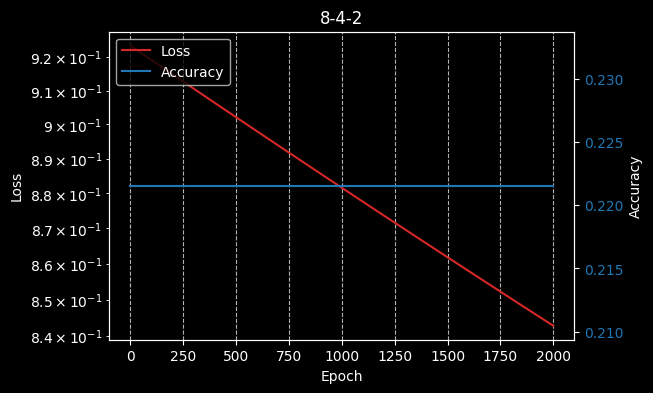

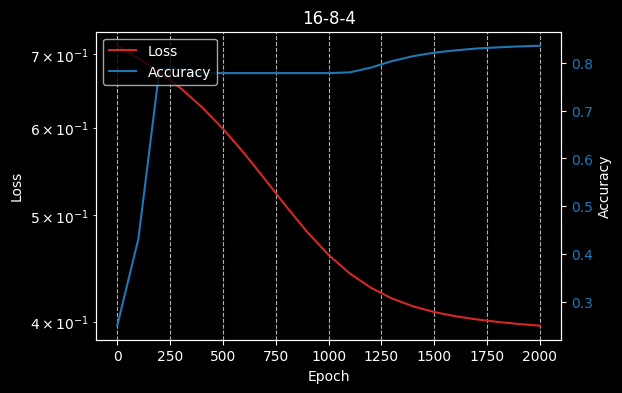

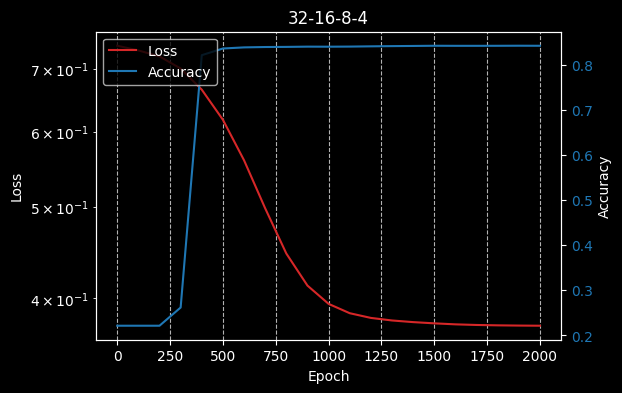

In [26]:
results_graphs(arch_results, EPOCHS)

### 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях. 

https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

In [27]:
class NetCustomActivation(nn.Module):
    def __init__(self, n_features, activation_func):
        super(NetCustomActivation, self).__init__()

        self.fc1 = nn.Linear(n_features, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)

        self.activation_func = activation_func
    
        # torch.nn.init.xavier_uniform_(self.fc1.weight) 

    def forward(self, x):
        x = self.activation_func(self.fc1(x))
        x = self.activation_func(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [28]:
activation_functions = {
    'ReLU': F.relu,
    'Sigmoid': torch.sigmoid,
    'TanH': torch.tanh,
    'Leaky ReLU': F.leaky_relu
}

In [29]:
activation_results = {}

for func_name, func in log_progress(activation_functions.items(), name='Architectures'):
    net = NetCustomActivation(4, func)
    optimizer = optim.Adam(net.parameters(), lr=optimal_learning_rate)
    
    net = net.to(device)
    criterion = nn.BCELoss().to(device)

    losses, accuracies = run_training(net, optimizer, criterion, EPOCHS, X_train, X_test, y_train, y_test)

    activation_results[func_name] = {'loss': losses, 'accuracy': accuracies}

Epoch 0: Test set - loss: 0.8014469743, accuracy: 0.2215093374
Epoch 100: Test set - loss: 0.7937663794, accuracy: 0.2215494365
Epoch 200: Test set - loss: 0.7856199741, accuracy: 0.2215494365
Epoch 300: Test set - loss: 0.7768675685, accuracy: 0.2215494365
Epoch 400: Test set - loss: 0.7674281597, accuracy: 0.2215494365
Epoch 500: Test set - loss: 0.7572016716, accuracy: 0.2215494365
Epoch 600: Test set - loss: 0.7460425496, accuracy: 0.2215494365
Epoch 700: Test set - loss: 0.7338767648, accuracy: 0.2230331302
Epoch 800: Test set - loss: 0.7207405567, accuracy: 0.2474536896
Epoch 900: Test set - loss: 0.7067070007, accuracy: 0.3515117466
Epoch 1000: Test set - loss: 0.6918128729, accuracy: 0.5016039610
Epoch 1100: Test set - loss: 0.6752569675, accuracy: 0.6365386248
Epoch 1200: Test set - loss: 0.6493148804, accuracy: 0.7438046336
Epoch 1300: Test set - loss: 0.6153152585, accuracy: 0.8031919003
Epoch 1400: Test set - loss: 0.5790718198, accuracy: 0.8088058233
Epoch 1500: Test set -

Epoch 0: Test set - loss: 1.0084501505, accuracy: 0.2215494365
Epoch 100: Test set - loss: 0.9858394265, accuracy: 0.2215494365
Epoch 200: Test set - loss: 0.9642341137, accuracy: 0.2215494365
Epoch 300: Test set - loss: 0.9435888529, accuracy: 0.2215494365
Epoch 400: Test set - loss: 0.9238453507, accuracy: 0.2215494365
Epoch 500: Test set - loss: 0.9049524665, accuracy: 0.2215494365
Epoch 600: Test set - loss: 0.8868693113, accuracy: 0.2215494365
Epoch 700: Test set - loss: 0.8695576191, accuracy: 0.2215494365
Epoch 800: Test set - loss: 0.8529800177, accuracy: 0.2215494365
Epoch 900: Test set - loss: 0.8371011615, accuracy: 0.2215494365
Epoch 1000: Test set - loss: 0.8218879700, accuracy: 0.2215494365
Epoch 1100: Test set - loss: 0.8073083758, accuracy: 0.2215494365
Epoch 1200: Test set - loss: 0.7933285236, accuracy: 0.2215494365
Epoch 1300: Test set - loss: 0.7799124122, accuracy: 0.2215494365
Epoch 1400: Test set - loss: 0.7670208216, accuracy: 0.2215494365
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.7883745432, accuracy: 0.2215494365
Epoch 100: Test set - loss: 0.7748737335, accuracy: 0.2215494365
Epoch 200: Test set - loss: 0.7611202598, accuracy: 0.2215494365
Epoch 300: Test set - loss: 0.7466612458, accuracy: 0.2215494365
Epoch 400: Test set - loss: 0.7310865521, accuracy: 0.2215494365
Epoch 500: Test set - loss: 0.7144553065, accuracy: 0.3278931677
Epoch 600: Test set - loss: 0.6970801950, accuracy: 0.5137140155
Epoch 700: Test set - loss: 0.6792929173, accuracy: 0.6301628351
Epoch 800: Test set - loss: 0.6613907218, accuracy: 0.6960461736
Epoch 900: Test set - loss: 0.6436338425, accuracy: 0.7327371836
Epoch 1000: Test set - loss: 0.6262496710, accuracy: 0.7559146881
Epoch 1100: Test set - loss: 0.6094281673, accuracy: 0.7705509663
Epoch 1200: Test set - loss: 0.5933104157, accuracy: 0.7830619812
Epoch 1300: Test set - loss: 0.5779874921, accuracy: 0.7942497134
Epoch 1400: Test set - loss: 0.5635114908, accuracy: 0.8029914498
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.7081589103, accuracy: 0.3568449914
Epoch 100: Test set - loss: 0.6961152554, accuracy: 0.4565722942
Epoch 200: Test set - loss: 0.6839516759, accuracy: 0.5384954810
Epoch 300: Test set - loss: 0.6716343760, accuracy: 0.6187344790
Epoch 400: Test set - loss: 0.6593081951, accuracy: 0.6899911761
Epoch 500: Test set - loss: 0.6471868157, accuracy: 0.7502606511
Epoch 600: Test set - loss: 0.6352298260, accuracy: 0.7900794148
Epoch 700: Test set - loss: 0.6232455969, accuracy: 0.8206752539
Epoch 800: Test set - loss: 0.6112024784, accuracy: 0.8246451020
Epoch 900: Test set - loss: 0.5991314650, accuracy: 0.8268104792
Epoch 1000: Test set - loss: 0.5870513320, accuracy: 0.8284545541
Epoch 1100: Test set - loss: 0.5750017166, accuracy: 0.8302991390
Epoch 1200: Test set - loss: 0.5629789829, accuracy: 0.8322238922
Epoch 1300: Test set - loss: 0.5510347486, accuracy: 0.8333467245
Epoch 1400: Test set - loss: 0.5390799642, accuracy: 0.8335471749
Epoch 1500: Test set -

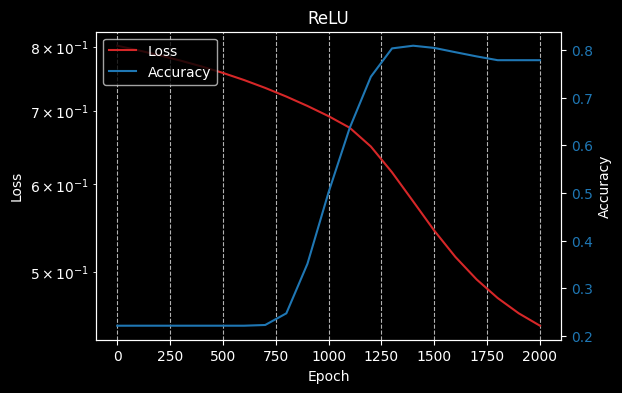

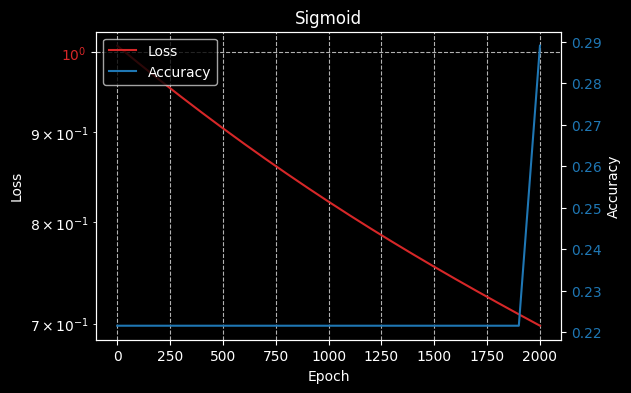

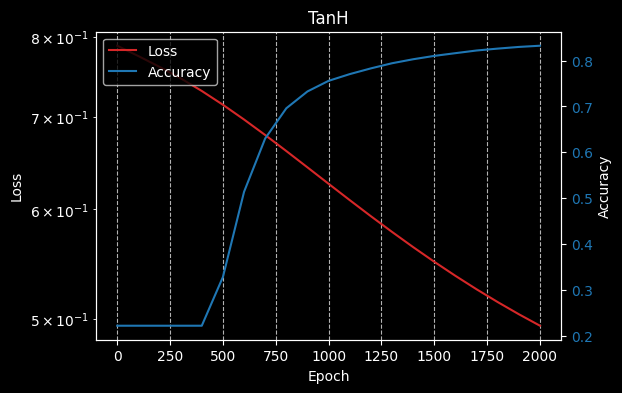

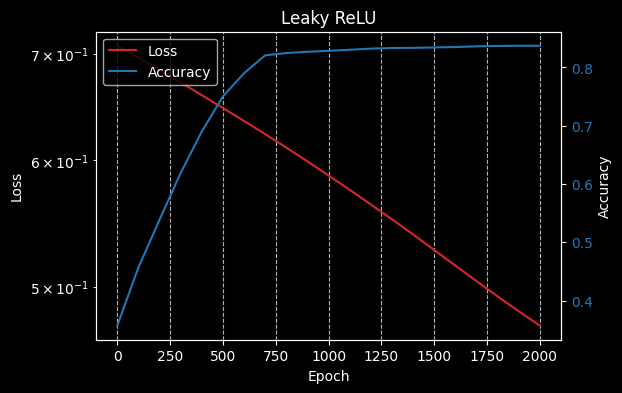

In [30]:
results_graphs(activation_results, EPOCHS)

5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации. 

In [31]:
optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop
}

In [32]:
optimizers_results = {}

for optim_name, optim_class in log_progress(optimizers.items(), name='Architectures'):
    net = Net(4)
    optimizer = optim_class(net.parameters(), lr=optimal_learning_rate)
    
    net = net.to(device)
    criterion = nn.BCELoss().to(device)

    losses, accuracies = run_training(net, optimizer, criterion, EPOCHS, X_train, X_test, y_train, y_test)

    optimizers_results[optim_name] = {'loss': losses, 'accuracy': accuracies}

Epoch 0: Test set - loss: 0.5995065570, accuracy: 0.7804555297
Epoch 100: Test set - loss: 0.5990878940, accuracy: 0.7804555297
Epoch 200: Test set - loss: 0.5986717343, accuracy: 0.7804154158
Epoch 300: Test set - loss: 0.5982580185, accuracy: 0.7803753614
Epoch 400: Test set - loss: 0.5978467464, accuracy: 0.7803753614
Epoch 500: Test set - loss: 0.5974377394, accuracy: 0.7803352475
Epoch 600: Test set - loss: 0.5970313549, accuracy: 0.7803352475
Epoch 700: Test set - loss: 0.5966272950, accuracy: 0.7802951336
Epoch 800: Test set - loss: 0.5962255001, accuracy: 0.7802951336
Epoch 900: Test set - loss: 0.5958260298, accuracy: 0.7803352475
Epoch 1000: Test set - loss: 0.5954290032, accuracy: 0.7803352475
Epoch 1100: Test set - loss: 0.5950342417, accuracy: 0.7803352475
Epoch 1200: Test set - loss: 0.5946416855, accuracy: 0.7803352475
Epoch 1300: Test set - loss: 0.5942513347, accuracy: 0.7803352475
Epoch 1400: Test set - loss: 0.5938634276, accuracy: 0.7802550197
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.8325380683, accuracy: 0.2215093374
Epoch 100: Test set - loss: 0.8240948319, accuracy: 0.2215093374
Epoch 200: Test set - loss: 0.8151388764, accuracy: 0.2215093374
Epoch 300: Test set - loss: 0.8056101799, accuracy: 0.2215093374
Epoch 400: Test set - loss: 0.7954589725, accuracy: 0.2215494365
Epoch 500: Test set - loss: 0.7846777439, accuracy: 0.2215093374
Epoch 600: Test set - loss: 0.7733023167, accuracy: 0.2241559029
Epoch 700: Test set - loss: 0.7613758445, accuracy: 0.2341406643
Epoch 800: Test set - loss: 0.7489035130, accuracy: 0.2523458302
Epoch 900: Test set - loss: 0.7358738184, accuracy: 0.2837035954
Epoch 1000: Test set - loss: 0.7222883701, accuracy: 0.3288154602
Epoch 1100: Test set - loss: 0.7081375718, accuracy: 0.3910498023
Epoch 1200: Test set - loss: 0.6934434772, accuracy: 0.4645119905
Epoch 1300: Test set - loss: 0.6782494187, accuracy: 0.5364905000
Epoch 1400: Test set - loss: 0.6626341343, accuracy: 0.6028952003
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.6998941898, accuracy: 0.3110113144
Epoch 100: Test set - loss: 0.6796203256, accuracy: 0.5441094041
Epoch 200: Test set - loss: 0.6657589078, accuracy: 0.7323362231
Epoch 300: Test set - loss: 0.6519383788, accuracy: 0.7747213244
Epoch 400: Test set - loss: 0.6376456022, accuracy: 0.7783302665
Epoch 500: Test set - loss: 0.6229492426, accuracy: 0.7784505486
Epoch 600: Test set - loss: 0.6078277230, accuracy: 0.7784505486
Epoch 700: Test set - loss: 0.5922164321, accuracy: 0.7784505486
Epoch 800: Test set - loss: 0.5768706799, accuracy: 0.7784505486
Epoch 900: Test set - loss: 0.5619843602, accuracy: 0.7784505486
Epoch 1000: Test set - loss: 0.5475339293, accuracy: 0.7784505486
Epoch 1100: Test set - loss: 0.5335831642, accuracy: 0.7784505486
Epoch 1200: Test set - loss: 0.5202152729, accuracy: 0.7784505486
Epoch 1300: Test set - loss: 0.5075012445, accuracy: 0.7784505486
Epoch 1400: Test set - loss: 0.4954876304, accuracy: 0.7784505486
Epoch 1500: Test set -

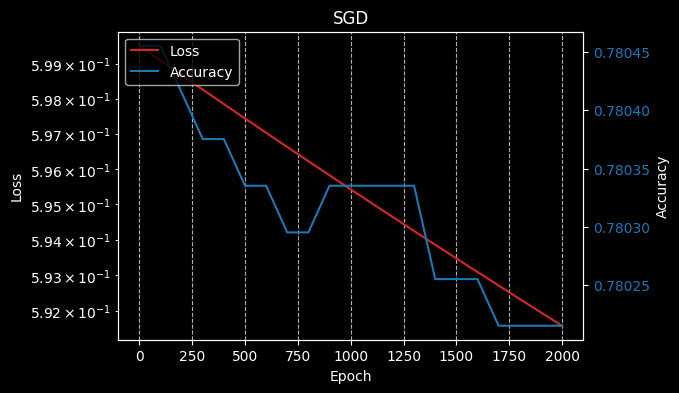

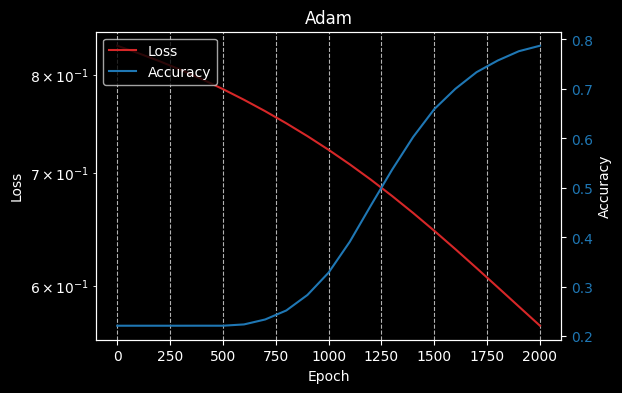

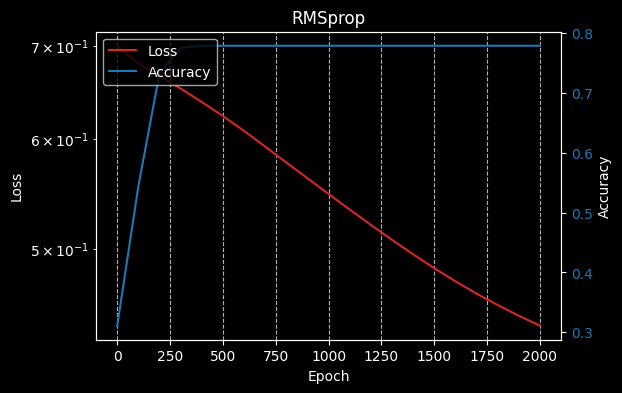

In [33]:
results_graphs(optimizers_results, EPOCHS)

### 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

In [34]:
def initialize_weights(model, func, **params):
    if func is None:
        return model

    for m in model.modules():
        if isinstance(m, nn.Linear):
            func(m.weight, **params)
            nn.init.zeros_(m.bias)

    return model

In [35]:
init_functions = {
    'Zeros': (nn.init.zeros_, {}),
    'Random': (nn.init.normal_, { 'mean': 0.0, 'std': 0.01 }),
    'Xavier': (torch.nn.init.xavier_uniform_, {}),
    'He': (nn.init.kaiming_normal_, { 'nonlinearity': 'relu' }),
}

In [36]:
init_results = {}

for init_name, (init_func, init_params) in log_progress(init_functions.items(), name='Architectures'):
    net = Net(4)
    net = initialize_weights(net, init_func, **init_params)

    optimizer = optim.Adam(net.parameters(), lr=optimal_learning_rate)
    
    net = net.to(device)
    criterion = nn.BCELoss().to(device)

    losses, accuracies = run_training(net, optimizer, criterion, EPOCHS, X_train, X_test, y_train, y_test)

    init_results[init_name] = {'loss': losses, 'accuracy': accuracies}

Epoch 0: Test set - loss: 0.6931193471, accuracy: 0.7784505486
Epoch 100: Test set - loss: 0.6903520823, accuracy: 0.7784505486
Epoch 200: Test set - loss: 0.6876209378, accuracy: 0.7784505486
Epoch 300: Test set - loss: 0.6849262118, accuracy: 0.7784505486
Epoch 400: Test set - loss: 0.6822667718, accuracy: 0.7784505486
Epoch 500: Test set - loss: 0.6796423793, accuracy: 0.7784505486
Epoch 600: Test set - loss: 0.6770523190, accuracy: 0.7784505486
Epoch 700: Test set - loss: 0.6744958162, accuracy: 0.7784505486
Epoch 800: Test set - loss: 0.6719724536, accuracy: 0.7784505486
Epoch 900: Test set - loss: 0.6694816351, accuracy: 0.7784505486
Epoch 1000: Test set - loss: 0.6670226455, accuracy: 0.7784505486
Epoch 1100: Test set - loss: 0.6645952463, accuracy: 0.7784505486
Epoch 1200: Test set - loss: 0.6621988416, accuracy: 0.7784505486
Epoch 1300: Test set - loss: 0.6598326564, accuracy: 0.7784505486
Epoch 1400: Test set - loss: 0.6574964523, accuracy: 0.7784505486
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.6931184530, accuracy: 0.7784505486
Epoch 100: Test set - loss: 0.6901782155, accuracy: 0.7784505486
Epoch 200: Test set - loss: 0.6868048310, accuracy: 0.7784505486
Epoch 300: Test set - loss: 0.6827473640, accuracy: 0.7784505486
Epoch 400: Test set - loss: 0.6778214574, accuracy: 0.7784906626
Epoch 500: Test set - loss: 0.6718849540, accuracy: 0.7792926431
Epoch 600: Test set - loss: 0.6648370624, accuracy: 0.7809367180
Epoch 700: Test set - loss: 0.6566197276, accuracy: 0.7849466801
Epoch 800: Test set - loss: 0.6472213864, accuracy: 0.7910016775
Epoch 900: Test set - loss: 0.6366794109, accuracy: 0.7993824482
Epoch 1000: Test set - loss: 0.6250793338, accuracy: 0.8079637289
Epoch 1100: Test set - loss: 0.6125465631, accuracy: 0.8155425191
Epoch 1200: Test set - loss: 0.5992381573, accuracy: 0.8219183683
Epoch 1300: Test set - loss: 0.5853264928, accuracy: 0.8250461221
Epoch 1400: Test set - loss: 0.5709857345, accuracy: 0.8278129697
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.8305611014, accuracy: 0.2173791081
Epoch 100: Test set - loss: 0.7967969179, accuracy: 0.2448873222
Epoch 200: Test set - loss: 0.7678093314, accuracy: 0.3853155971
Epoch 300: Test set - loss: 0.7427420020, accuracy: 0.5356484056
Epoch 400: Test set - loss: 0.7208415270, accuracy: 0.5689309239
Epoch 500: Test set - loss: 0.7021992207, accuracy: 0.6039377451
Epoch 600: Test set - loss: 0.6871246696, accuracy: 0.6338920593
Epoch 700: Test set - loss: 0.6742512584, accuracy: 0.6650092006
Epoch 800: Test set - loss: 0.6626497507, accuracy: 0.6952843070
Epoch 900: Test set - loss: 0.6517250538, accuracy: 0.7286871672
Epoch 1000: Test set - loss: 0.6411946416, accuracy: 0.7592028379
Epoch 1100: Test set - loss: 0.6309599280, accuracy: 0.7768064737
Epoch 1200: Test set - loss: 0.6208804250, accuracy: 0.7783302665
Epoch 1300: Test set - loss: 0.6108788252, accuracy: 0.7784104347
Epoch 1400: Test set - loss: 0.6008990407, accuracy: 0.7784505486
Epoch 1500: Test set -

Epoch 0: Test set - loss: 0.7235078216, accuracy: 0.7089983225
Epoch 100: Test set - loss: 0.6882407665, accuracy: 0.7494185567
Epoch 200: Test set - loss: 0.6560559273, accuracy: 0.7786510587
Epoch 300: Test set - loss: 0.6266987920, accuracy: 0.7923249602
Epoch 400: Test set - loss: 0.5999625325, accuracy: 0.7979388833
Epoch 500: Test set - loss: 0.5757516026, accuracy: 0.8012270331
Epoch 600: Test set - loss: 0.5540139079, accuracy: 0.8001042604
Epoch 700: Test set - loss: 0.5346469283, accuracy: 0.7993423939
Epoch 800: Test set - loss: 0.5174098015, accuracy: 0.7995428443
Epoch 900: Test set - loss: 0.5020654798, accuracy: 0.8000240922
Epoch 1000: Test set - loss: 0.4884517193, accuracy: 0.8002646565
Epoch 1100: Test set - loss: 0.4764017165, accuracy: 0.8018686175
Epoch 1200: Test set - loss: 0.4657956362, accuracy: 0.8027909398
Epoch 1300: Test set - loss: 0.4565664530, accuracy: 0.8040741086
Epoch 1400: Test set - loss: 0.4485803246, accuracy: 0.8049963713
Epoch 1500: Test set -

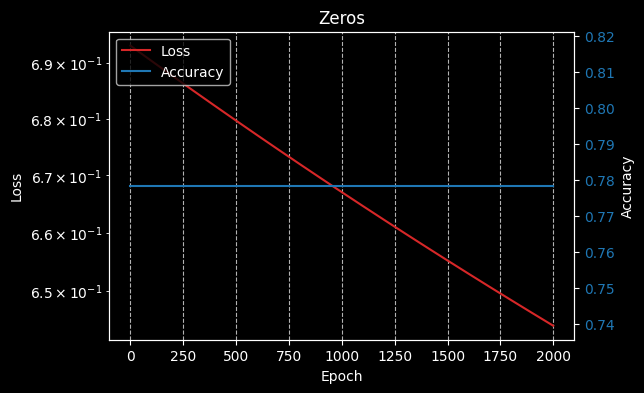

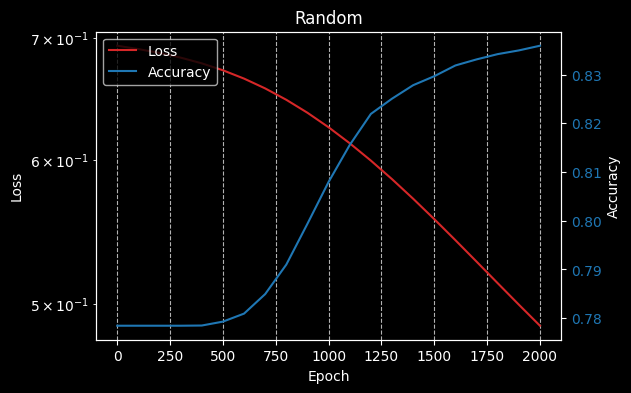

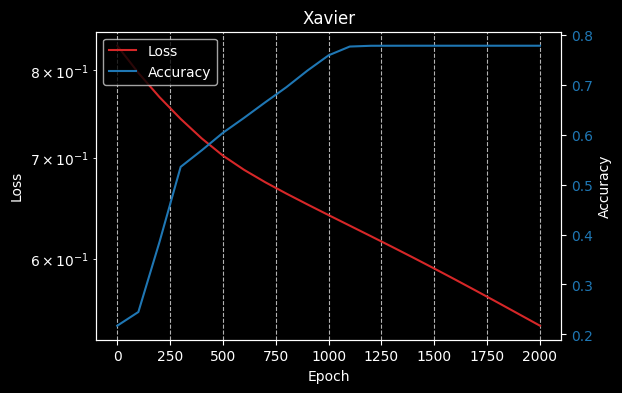

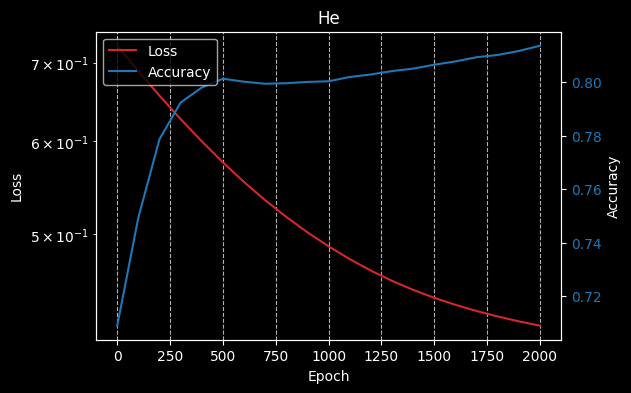

In [37]:
results_graphs(init_results, EPOCHS)